In [1]:
import rosbag_parser as rp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
rosbag_path = "rosbag2_2024_10_22-13_25_55"
scan_topic = "/scan"
ackermann_cmd_topic = "/drive"
odom_topic = "/ego_racecar/odom"

print(rp.get_rosbag_topics(rosbag_path))

bag = {"scan": rp.read_rosbag_scan(rosbag_path, scan_topic),
       "odom": rp.read_rosbag_odom(rosbag_path, odom_topic)}

['/map_updates', '/goal_pose', '/rosout', '/parameter_events', '/cmd_vel', '/drive', '/tf', '/ego_racecar/odom', '/tf_static', '/ego_robot_description', '/joint_states', '/clock', '/initialpose', '/map', '/scan']


## Clean data

In [3]:
t = []
x = []
y = []
initial_time = np.nan
for i, val in enumerate(bag["odom"]):
    if np.isnan(val.pose.pose.position.x ) or np.isnan(val.pose.pose.position.y):
        continue
    if np.isnan(initial_time):
        initial_time = val.header.stamp.sec + val.header.stamp.nanosec * 1e-9
    t.append((val.header.stamp.sec + val.header.stamp.nanosec * 1e-9)-initial_time)
    x.append(val.pose.pose.position.x)
    y.append(val.pose.pose.position.y)
pandas_data = pd.DataFrame(data={"t":t, "x": x, "y": y})

(2000, 2000)


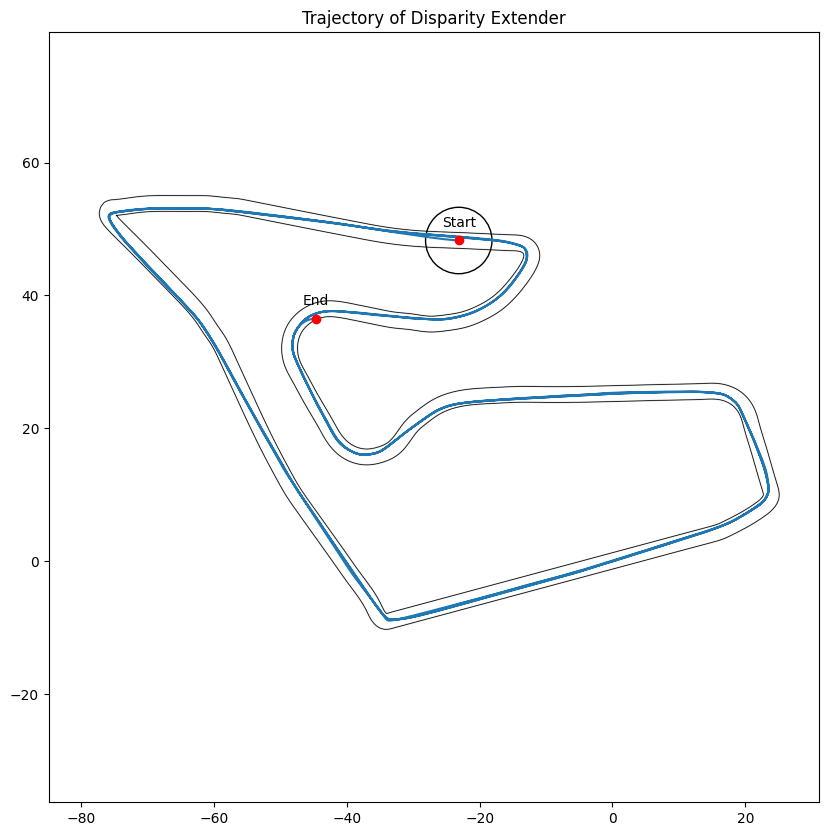

In [4]:
im = plt.imread("../f1tenth_ws/src/maps/maps/Spielberg_map.png")
print(im.shape)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(pandas_data["x"], pandas_data["y"])
ax.set_aspect('equal')
ax.set_title("Trajectory of Disparity Extender")
origin = [-84.85359914210505, -36.30299725862132]
resolution = 0.05796
start_point = [pandas_data["x"].iloc[0], pandas_data["y"].iloc[0]]
ax.annotate("Start", (start_point[0], start_point[1]), textcoords="offset points", xytext=(0,10), ha='center')
ax.plot(start_point[0], start_point[1], 'ro')
end_point = [pandas_data["x"].iloc[-1], pandas_data["y"].iloc[-1]]
ax.plot(end_point[0], end_point[1], 'ro')
ax.annotate("End", (end_point[0], end_point[1]), textcoords="offset points", xytext=(0,10), ha='center')

ax.imshow(im, cmap='Greys_r', extent=[origin[0], origin[0]+im.shape[0]*resolution, origin[1], origin[1]+im.shape[1]*resolution])

cr = mpatches.Circle(start_point, 5, fill=False)
ax.add_patch(cr)

plt.show()

In [5]:
r = 5
near = True
lap_time = []
lap_start = np.inf
for i, t in enumerate(pandas_data["t"]):
    x = pandas_data["x"].iloc[i]
    y = pandas_data["y"].iloc[i]
    distance = np.sqrt((x-start_point[0])**2 + (y-start_point[1])**2)
    if distance >= r and near:
        if lap_start != np.inf:
            lap_time.append(t-lap_start)
        lap_start = t
        near = False
    if not near:
        if distance < r:
            near = True
print(lap_time)

[44.190855264663696, 44.42729043960571, 44.233336210250854]


In [6]:
map_path = "../f1tenth_ws/src/maps/maps/Spielberg_map"
with open(map_path + ".yaml") as file:
    for line in file:
        if "resolution" in line:
            list_line = line.split()
            resolution = float(list_line[1])
            print(resolution)
        if "origin" in line:
            origin = []
            list_line = line.split(":")
            list_line = list_line[-1].split("]")
            list_line = list_line[0].split("[")
            list_line = list_line[-1].split(",")
            for l in list_line:
                l = l.strip()
                origin.append(float(l))
            print(origin)

0.05796
[-84.85359914210505, -36.30299725862132, 0.0]


0.05796


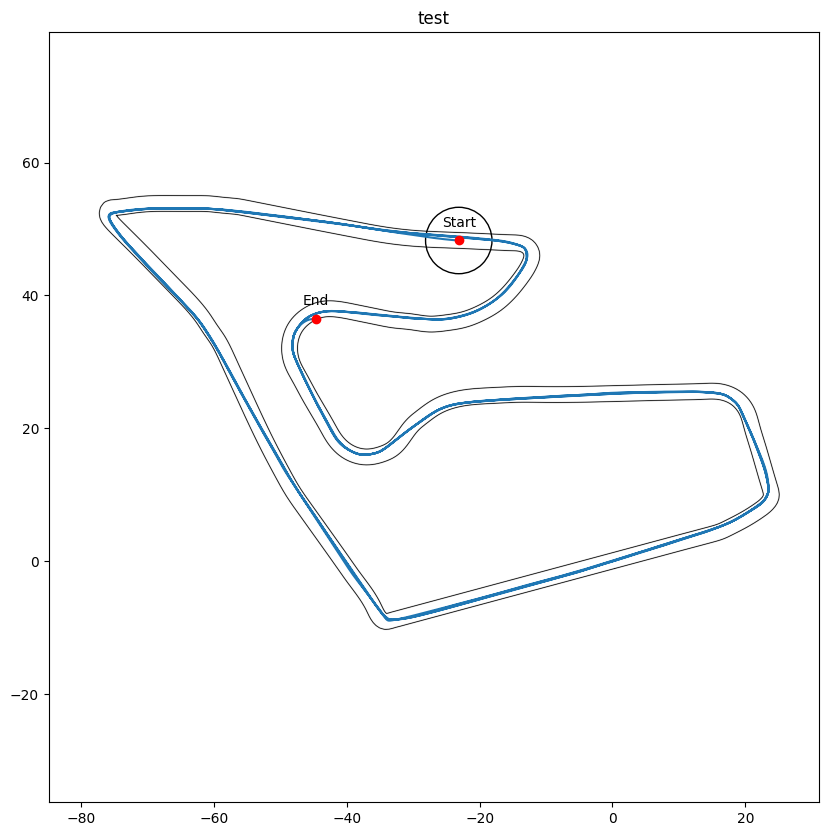

[44.190855264663696, 44.42729043960571, 44.233336210250854]


In [1]:
import performance
rosbag_path = "rosbag2_2024_10_22-13_25_55"
odom_topic = "/ego_racecar/odom"
map_path = "../f1tenth_ws/src/maps/maps/Spielberg_map"
r = 5
performance.plot_trajectory(rosbag_path, map_path, odom_topic, "test", r)